In [4]:
import numpy as np
import matplotlib.pyplot as plt
import openmdao.api as om
import dymos as dm
import os

In [5]:
class QuadODE(om.ExplicitComponent):
    def initialize(self):
        self.options.declare("num_nodes", types=int)

    def setup(self):
        nn = self.options["num_nodes"]
        
        # Motor inputs, control variables
        self.add_input(
            "w1",
            val=np.zeros(nn),
            desc="angular velocity of propeller 1",
            units="rad/s",
        )
        self.add_input(
            "w2",
            val=np.zeros(nn),
            desc="angular velocity of propeller 2",
            units="rad/s",
        )
        self.add_input(
            "w3",
            val=np.zeros(nn),
            desc="angular velocity of propeller 3",
            units="rad/s",
        )
        self.add_input(
            "w4",
            val=np.zeros(nn),
            desc="angular velocity of propeller 4",
            units="rad/s",
        )


        # Static parameters
        # Quadrotor parameters,constants
        self.add_input("g", val=9.81, desc="gravity", units="m/s**2")
        self.add_input("l", val=0.2, desc="moment arm", units="m")
        self.add_input("m", val=0.2, desc="mass", units="kg")

        self.add_input(
            "Ixx",
            val=0.2,
            desc="moment of inertia about x axis",
            units="kg*m**2",
        )
        self.add_input(
            "Iyy",
            val=0.2,
            desc="moment of inertia about y axis",
            units="kg*m**2",
        )
        self.add_input(
            "Izz",
            val=0.2,
            desc="moment of inertia about z axis",
            units="kg*m**2",
        )
        # Input the x,y,z coordinates of the obstacle
        self.add_input("x_obs", val=1, desc="x position of obstacle", units="m")
        self.add_input("y_obs", val=1, desc="y position of obstacle", units="m")
        self.add_input("z_obs", val=1, desc="z position of obstacle", units="m")
        
        # Input the radius of the obstacle
        self.add_input("r_obs", val=1, desc="radius of obstacle", units="m")

        self.add_input(
            "Kt", val=0.002, desc="thrust coefficient", units="N/rad**2"
        )
        
                
        # States, variables
        self.add_input("phi", val=np.zeros(nn), desc="Pitch angle", units="rad")
        self.add_input("theta", val=np.zeros(nn), desc="Roll angle", units="rad")
        self.add_input("psi", val=np.zeros(nn), desc="Yaw angle", units="rad")

        self.add_input("x", val=np.zeros(nn), desc="x position", units="m")
        self.add_input("y", val=np.zeros(nn), desc="y position", units="m")
        self.add_input("z", val=np.zeros(nn), desc="z position", units="m")
        

        # Outputs
        self.add_output(
            "x_ddot", val=np.zeros(nn), desc="x acceleration", units="m/s**2"
        )
        self.add_output(
            "y_ddot", val=np.zeros(nn), desc="y acceleration", units="m/s**2"
        )
        self.add_output(
            "z_ddot", val=np.zeros(nn), desc="z acceleration", units="m/s**2"
        )
        self.add_output(
            "phi_ddot", val=np.zeros(nn), desc="Pitch acceleration", units="rad/s**2"
        )
        self.add_output(
            "theta_ddot", val=np.zeros(nn), desc="Roll acceleration", units="rad/s**2"
        )
        self.add_output(
            "psi_ddot", val=np.zeros(nn), desc="Yaw acceleration", units="rad/s**2"
        )
        
        self.add_output("ineq_constraint", val=np.zeros(nn), desc="inequality constraint that distance between quadrotor and obstacle is greater than radius of obstacle", units="m")

    def setup_partials(self):
        nn = self.options["num_nodes"]
        arange = np.arange(nn)
    
        self.declare_partials(of='x_ddot', wrt=['phi', 'theta', 'psi', 'w1', 'w2', 'w3', 'w4'], rows=arange, cols=arange)
        self.declare_partials(of='y_ddot', wrt=['phi', 'theta', 'psi', 'w1', 'w2', 'w3', 'w4'], rows=arange, cols=arange)
        self.declare_partials(of='z_ddot', wrt=['phi', 'theta', 'w1', 'w2', 'w3', 'w4'], rows=arange, cols=arange)
        
        self.declare_partials(of='phi_ddot', wrt=['w1', 'w2', 'w3', 'w4'], rows=arange, cols=arange)
        self.declare_partials(of='theta_ddot', wrt=['w1', 'w2', 'w3', 'w4'], rows=arange, cols=arange)
        self.declare_partials(of='psi_ddot', wrt=['w1', 'w2', 'w3', 'w4'], rows=arange, cols=arange)
        
        self.declare_partials(of='ineq_constraint', wrt=['x', 'y', 'z'], rows=arange, cols=arange)
    def compute(self, inputs, outputs):
        # Inputs
        g = inputs["g"]
        l = inputs["l"]
        m = inputs["m"]
        
        Ixx = inputs["Ixx"]
        Iyy = inputs["Iyy"]
        Izz = inputs["Izz"]
        
        w1 = inputs["w1"]
        w2 = inputs["w2"]
        w3 = inputs["w3"]
        w4 = inputs["w4"]
        Kt = inputs["Kt"]
                
        U1 = Kt * (w1**2 + w2**2 + w3**2 + w4**2)
        U2 = Kt * (w4**2 - w2**2)
        U3 = Kt * (w3**2 - w1**2)
        U4 = Kt * (w1**2 + w3**2 - w2**2 - w4**2)
        
        phi = inputs["phi"]
        theta = inputs["theta"]
        psi = inputs["psi"]
        
        x = inputs["x"]
        y = inputs["y"]
        z = inputs["z"]
        
        x_obs = inputs["x_obs"]
        y_obs = inputs["y_obs"]
        z_obs = inputs["z_obs"]

        comp1 = np.sin(phi) * np.sin(psi) + np.cos(phi) * np.cos(psi) * np.sin(theta)
        comp2 = np.sin(psi) * np.sin(theta) * np.cos(phi) - np.cos(psi) * np.sin(phi)
        comp3 = np.cos(phi) * np.cos(theta)
        outputs["x_ddot"] = 1 / m * (U1 * comp1)
        outputs["y_ddot"] = 1 / m * (U1 * comp2)
        outputs["z_ddot"] = 1 / m * (U1 * comp3 - g)
        outputs["phi_ddot"] = l / Ixx * (U2)
        outputs["theta_ddot"] = l / Iyy * (U3)
        outputs["psi_ddot"] = l / Izz * (U4)
        
        dist = np.sqrt((x - x_obs)**2 + (y - y_obs)**2 + (z - z_obs)**2)
        outputs["ineq_constraint"] = dist - inputs["r_obs"]
    def compute_partials(self, inputs, partials):
        # Inputs
        g = inputs["g"]
        l = inputs["l"]
        m = inputs["m"]
        
        Ixx = inputs["Ixx"]
        Iyy = inputs["Iyy"]
        Izz = inputs["Izz"]
        
        w1 = inputs["w1"]
        w2 = inputs["w2"]
        w3 = inputs["w3"]
        w4 = inputs["w4"]
        Kt = inputs["Kt"]
                
        U1 = Kt * (w1**2 + w2**2 + w3**2 + w4**2)
        
        phi = inputs["phi"]
        theta = inputs["theta"]
        psi = inputs["psi"]
        
        x = inputs["x"]
        y = inputs["y"]
        z = inputs["z"]
        
        x_obs = inputs["x_obs"]
        y_obs = inputs["y_obs"]
        z_obs = inputs["z_obs"]
                
        # Partials
        partials['x_ddot', 'phi'] = (U1 * (-(np.cos(psi) * np.sin(theta) * np.sin(phi)) + np.cos(phi) * np.sin(psi))) / m
        partials['x_ddot', 'theta'] = (U1 * np.cos(theta) * np.cos(phi) * np.cos(psi)) / m
        partials['x_ddot', 'psi'] = 1 / m * (U1 * np.cos(psi) * np.sin(phi) * np.sin(theta))
        partials['x_ddot', 'w1'] = 2 * Kt * w1 / m * (np.sin(phi) * np.sin(psi) + np.cos(phi) * np.cos(psi) * np.sin(theta))
        partials['x_ddot', 'w2'] = 2 * Kt * w2 / m * (np.sin(phi) * np.sin(psi) + np.cos(phi) * np.cos(psi) * np.sin(theta))
        partials['x_ddot', 'w3'] = 2 * Kt * w3 / m * (np.sin(phi) * np.sin(psi) + np.cos(phi) * np.cos(psi) * np.sin(theta))
        partials['x_ddot', 'w4'] = 2 * Kt * w4 / m * (np.sin(phi) * np.sin(psi) + np.cos(phi) * np.cos(psi) * np.sin(theta))
        
        partials['y_ddot', 'phi'] = -((U1 * (np.cos(phi) * np.cos(psi) + np.sin(theta) * np.sin(phi) * np.sin(psi))) / m)
        partials['y_ddot', 'theta'] = (U1 * np.cos(theta) * np.cos(phi) * np.sin(psi)) / m
        partials['y_ddot', 'psi'] = (U1 * (np.cos(phi) * np.cos(psi) * np.sin(theta) + np.sin(phi) * np.sin(psi))) / m
        partials['y_ddot', 'w1'] = 2 * Kt * w1 / m * (np.sin(psi) * np.sin(theta) * np.cos(phi) - np.cos(psi) * np.sin(phi))
        partials['y_ddot', 'w2'] = 2 * Kt * w2 / m * (np.sin(psi) * np.sin(theta) * np.cos(phi) - np.cos(psi) * np.sin(phi))
        partials['y_ddot', 'w3'] = 2 * Kt * w3 / m * (np.sin(psi) * np.sin(theta) * np.cos(phi) - np.cos(psi) * np.sin(phi))
        partials['y_ddot', 'w4'] = 2 * Kt * w4 / m * (np.sin(psi) * np.sin(theta) * np.cos(phi) - np.cos(psi) * np.sin(phi))
        
        partials['z_ddot', 'phi'] = -((U1 * np.cos(theta) * np.sin(phi)) / m)
        partials['z_ddot', 'theta'] = -((U1 * np.cos(phi) * np.sin(theta)) / m)
        partials['z_ddot', 'w1'] = 2 * Kt * w1 / m * (np.cos(phi) * np.cos(theta))
        partials['z_ddot', 'w2'] = 2 * Kt * w2 / m * (np.cos(phi) * np.cos(theta))
        partials['z_ddot', 'w3'] = 2 * Kt * w3 / m * (np.cos(phi) * np.cos(theta))
        partials['z_ddot', 'w4'] = 2 * Kt * w4 / m * (np.cos(phi) * np.cos(theta))
        
        partials['phi_ddot', 'w1'] = 0
        partials['phi_ddot', 'w2'] = -2 * Kt * w2 * l / Ixx
        partials['phi_ddot', 'w3'] = 0
        partials['phi_ddot', 'w4'] = 2 * Kt * w4 * l / Ixx
        
        partials['theta_ddot', 'w1'] = -2 * Kt * w1 * l / Iyy
        partials['theta_ddot', 'w2'] = 0
        partials['theta_ddot', 'w3'] = 2 * Kt * w3 * l / Iyy
        partials['theta_ddot', 'w4'] = 0
        
        partials['psi_ddot', 'w1'] = 2 * Kt * w1 * l / Izz
        partials['psi_ddot', 'w2'] = -2 * Kt * w2 * l / Izz
        partials['psi_ddot', 'w3'] = 2 * Kt * w3 * l / Izz
        partials['psi_ddot', 'w4'] = -2 * Kt * w4 * l / Izz
        
        partials['ineq_constraint', 'x'] = (-x_obs + x) / np.sqrt((-x_obs + x)**2 + (-y_obs + y)**2 + (-z_obs + z)**2)
        partials['ineq_constraint', 'y'] = (-y_obs + y) / np.sqrt((-x_obs + x)**2 + (-y_obs + y)**2 + (-z_obs + z)**2)
        partials['ineq_constraint', 'z'] = (-z_obs + z) / np.sqrt((-x_obs + x)**2 + (-y_obs + y)**2 + (-z_obs + z)**2)

        

In [ ]:
# # Check the analytic derivatives for the quadrotor model
# num_nodes = 5

# test = om.Problem(model=om.Group())

# ivc = test.model.add_subsystem("ivc", om.IndepVarComp(), promotes_outputs=["*"])
# ivc.add_output("w1", val=100*np.random.random(num_nodes), units="rad/s")
# ivc.add_output("w2", val=100*np.random.random(num_nodes), units="rad/s")
# ivc.add_output("w3", val=100*np.random.random(num_nodes), units="rad/s")
# ivc.add_output("w4", val=100*np.random.random(num_nodes), units="rad/s")

# ivc.add_output("phi", val=1*np.ones(num_nodes), units="rad")
# ivc.add_output("theta", val=2*np.ones(num_nodes), units="rad")
# ivc.add_output("psi", val=1*np.ones(num_nodes), units="rad")

# ivc.add_output("Kt", val=1.7*np.ones(num_nodes), units="N/rad**2")
# ivc.add_output("g", val=9.81*np.ones(num_nodes), units="m/s**2")
# ivc.add_output("l", val=5*np.ones(num_nodes), units="m")
# ivc.add_output("m", val=3*np.ones(num_nodes), units="kg")
# ivc.add_output("Ixx", val=2*np.ones(num_nodes), units="kg*m**2")
# ivc.add_output("Iyy", val=2*np.ones(num_nodes), units="kg*m**2")
# ivc.add_output("Izz", val=2*np.ones(num_nodes), units="kg*m**2")

# ivc.add_output("x", val=1*np.ones(num_nodes), units="m")
# ivc.add_output("y", val=2*np.ones(num_nodes), units="m")
# ivc.add_output("z", val=3*np.ones(num_nodes), units="m")

# ivc.add_output("x_obs", val=3*np.ones(num_nodes), units="m")
# ivc.add_output("y_obs", val=3*np.ones(num_nodes), units="m")
# ivc.add_output("z_obs", val=3*np.ones(num_nodes), units="m")

# ivc.add_output("r_obs", val=1*np.ones(num_nodes), units="m")


# test.model.add_subsystem("quad_ode", QuadODE(num_nodes=num_nodes))

# test.model.connect("w1", "quad_ode.w1")
# test.model.connect("w2", "quad_ode.w2")
# test.model.connect("w3", "quad_ode.w3")
# test.model.connect("w4", "quad_ode.w4")
# test.model.connect("Kt", "quad_ode.Kt")
# test.model.connect("g", "quad_ode.g")
# test.model.connect("l", "quad_ode.l")
# test.model.connect("m", "quad_ode.m")
# test.model.connect("Ixx", "quad_ode.Ixx")
# test.model.connect("Iyy", "quad_ode.Iyy")
# test.model.connect("Izz", "quad_ode.Izz")
# test.model.connect("phi", "quad_ode.phi")
# test.model.connect("theta", "quad_ode.theta")
# test.model.connect("psi", "quad_ode.psi")
# test.model.connect("x", "quad_ode.x")
# test.model.connect("y", "quad_ode.y")
# test.model.connect("z", "quad_ode.z")
# test.model.connect("x_obs", "quad_ode.x_obs")
# test.model.connect("y_obs", "quad_ode.y_obs")
# test.model.connect("z_obs", "quad_ode.z_obs")
# test.model.connect("r_obs", "quad_ode.r_obs")


# test.setup(force_alloc_complex=True)

# test.run_model()
# cpd = test.check_partials(compact_print=True, method='cs')

In [6]:
# Multiple phases case with obstacles
num_nodes = 5
p = om.Problem(model=om.Group())
p.driver = om.pyOptSparseDriver()
p.driver.options['optimizer'] = 'IPOPT'
p.driver.declare_coloring()

# Add recorder
# recorder = om.SqliteRecorder('traj_obs_IPOPT.sql') # Record the results
# p.driver.add_recorder(recorder)

p.model.add_subsystem("motion_ode", QuadODE(num_nodes=num_nodes), promotes=["*"])

# Setup trajectory
traj = p.model.add_subsystem('traj', dm.Trajectory())
transcription = dm.Radau(num_segments=25, order=3, compressed=False)

# First phase
phase0 = dm.Phase(ode_class=QuadODE, transcription=transcription)
phase0 = traj.add_phase('phase0', phase0)

# Total duration of time need to be optimized
# Total two phases
phase0.set_time_options(fix_initial=True, duration_bounds=(1, 30), units='s')
phase0.add_state('x_dot', rate_source='x_ddot', fix_initial=True, fix_final=False, units='m/s')
phase0.add_state('y_dot', rate_source='y_ddot', fix_initial=True, fix_final=False, units='m/s')
phase0.add_state('z_dot', rate_source='z_ddot', fix_initial=True, fix_final=False, units='m/s')
phase0.add_state('x', fix_initial=True, fix_final=True, rate_source='x_dot', units='m')
phase0.add_state('y', fix_initial=True, fix_final=True, rate_source='y_dot', units='m')
phase0.add_state('z', fix_initial=True, fix_final=True, rate_source='z_dot', units='m')

phase0.add_state('phi_dot', rate_source='phi_ddot', fix_initial=True, fix_final=False, units='rad/s')
phase0.add_state('theta_dot', rate_source='theta_ddot', fix_initial=True, fix_final=False, units='rad/s')
phase0.add_state('psi_dot', rate_source='psi_ddot', fix_initial=True, fix_final=False, units='rad/s')
phase0.add_state('phi', fix_initial=True, fix_final=True, rate_source='phi_dot', units='rad')
phase0.add_state('theta', fix_initial=True, fix_final=True, rate_source='theta_dot', units='rad')
phase0.add_state('psi', fix_initial=True, fix_final=True, rate_source='psi_dot', units='rad')


phase0.add_control('w1', units='rad/s', lower=0, upper=1200, scaler=1,opt=True, rate_continuity=True)
phase0.add_control('w2', units='rad/s', lower=0, upper=1200, scaler=1,opt=True, rate_continuity=True)
phase0.add_control('w3', units='rad/s', lower=0, upper=1200, scaler=1,opt=True,rate_continuity=True)
phase0.add_control('w4', units='rad/s', lower=0, upper=1200, scaler=1,opt=True, rate_continuity=True)

# Parameters for the first phase
phase0.add_parameter('Kt',units='N/rad**2')
phase0.add_parameter('g', units='m/s**2')
phase0.add_parameter('l', units='m')
phase0.add_parameter('m', units='kg')
phase0.add_parameter('Ixx', units='kg*m**2')
phase0.add_parameter('Iyy', units='kg*m**2')
phase0.add_parameter('Izz', units='kg*m**2')
phase0.add_parameter('x_obs', units='m')
phase0.add_parameter('y_obs', units='m')
phase0.add_parameter('z_obs', units='m')
phase0.add_parameter('r_obs', units='m')


# Second phase
phase1 = dm.Phase(ode_class=QuadODE, transcription=transcription)
traj.add_phase('phase1', phase1)
# All initial states and time are free, since
#    they will be linked to the final states of the first phase
# Final altitude is fixed

phase1.set_time_options(initial_bounds=(1, 30), duration_bounds=(1, 30), units='s')
phase1.add_state('x_dot', rate_source='x_ddot', fix_initial=False, fix_final=True, units='m/s')
phase1.add_state('y_dot', rate_source='y_ddot', fix_initial=False, fix_final=True, units='m/s')
phase1.add_state('z_dot', rate_source='z_ddot', fix_initial=False, fix_final=True, units='m/s')
phase1.add_state('x', fix_initial=False, fix_final=True, rate_source='x_dot', units='m')
phase1.add_state('y', fix_initial=False, fix_final=True, rate_source='y_dot', units='m')
phase1.add_state('z', fix_initial=False, fix_final=True, rate_source='z_dot', units='m')

phase1.add_state('phi_dot', rate_source='phi_ddot', fix_initial=False, fix_final=True, units='rad/s')
phase1.add_state('theta_dot', rate_source='theta_ddot', fix_initial=False, fix_final=True, units='rad/s')
phase1.add_state('psi_dot', rate_source='psi_ddot', fix_initial=False, fix_final=True, units='rad/s')
phase1.add_state('phi', fix_initial=False, fix_final=True, rate_source='phi_dot', units='rad')
phase1.add_state('theta', fix_initial=False, fix_final=True, rate_source='theta_dot', units='rad')
phase1.add_state('psi', fix_initial=False, fix_final=True, rate_source='psi_dot', units='rad')

phase1.add_control('w1', units='rad/s', lower=0, upper=1200, scaler=1,opt=True, rate_continuity=True)
phase1.add_control('w2', units='rad/s', lower=0, upper=1200, scaler=1,opt=True, rate_continuity=True)
phase1.add_control('w3', units='rad/s', lower=0, upper=1200, scaler=1,opt=True, rate_continuity=True)
phase1.add_control('w4', units='rad/s', lower=0, upper=1200, scaler=1,opt=True, rate_continuity=True)

# Parameters for the second phase
phase1.add_parameter('Kt',units='N/rad**2')
phase1.add_parameter('g', units='m/s**2')
phase1.add_parameter('l', units='m')
phase1.add_parameter('m', units='kg')
phase1.add_parameter('Ixx', units='kg*m**2')
phase1.add_parameter('Iyy', units='kg*m**2')
phase1.add_parameter('Izz', units='kg*m**2')
phase1.add_parameter('x_obs', units='m')
phase1.add_parameter('y_obs', units='m')
phase1.add_parameter('z_obs', units='m')
phase1.add_parameter('r_obs', units='m')


# Parameters
traj.add_parameter('Kt',val=1.7e-5, units='N/rad**2')
traj.add_parameter('g', val=9.81, units='m/s**2')
traj.add_parameter('l', val=0.3, units='m')
traj.add_parameter('m', val=2, units='kg')
traj.add_parameter('Ixx', val=0.02, units='kg*m**2')
traj.add_parameter('Iyy', val=0.02, units='kg*m**2')
traj.add_parameter('Izz', val=0.03, units='kg*m**2')
traj.add_parameter('x_obs', val=5, units='m')
traj.add_parameter('y_obs', val=5, units='m')
traj.add_parameter('z_obs', val=0, units='m')
traj.add_parameter('r_obs', val=3, units='m')


# Link Phases (link time and all state variables)
traj.link_phases(phases=['phase0', 'phase1'], vars=['*'])

p.model.add_subsystem('time_calcs', om.ExecComp("f=t0+t1",t0={'units':'s'},t1={'units':'s'}))
p.model.connect('traj.phase0.t_duration_val', 'time_calcs.t0')
p.model.connect('traj.phase1.t_duration_val', 'time_calcs.t1')
p.model.add_objective('time_calcs.f',ref=1)


# Add constraints to trajectory
# Distance between quadrotor and obstacle must be greater than radius of obstacle + 2 m
phase0.add_path_constraint('ineq_constraint', lower=2,units='m')
phase1.add_path_constraint('ineq_constraint', lower=2,units='m')

# z coordinate of quadrotor must be greater than 0 and no more than 100 m
phase0.add_path_constraint('z', lower=0, upper=100,units='m')
phase1.add_path_constraint('z', lower=0, upper=100,units='m')

# x coordinate of quadrotor must be greater than 0 and no more than 100 m
phase0.add_path_constraint('x', lower=0, upper=50,units='m')
phase1.add_path_constraint('x', lower=0, upper=50,units='m')

# y coordinate of quadrotor must be greater than 0 and no more than 100 m
phase0.add_path_constraint('y', lower=0, upper=50,units='m')
phase1.add_path_constraint('y', lower=0, upper=50,units='m')

# phi, theta, psi must be between -pi and pi
phase0.add_path_constraint('phi', lower=-np.pi, upper=np.pi,units='rad')
phase1.add_path_constraint('phi', lower=-np.pi, upper=np.pi,units='rad')

phase0.add_path_constraint('theta', lower=-np.pi, upper=np.pi,units='rad')
phase1.add_path_constraint('theta', lower=-np.pi, upper=np.pi,units='rad')

phase0.add_path_constraint('psi', lower=-np.pi, upper=np.pi,units='rad')
phase1.add_path_constraint('psi', lower=-np.pi, upper=np.pi,units='rad')

# Initial and final conditions for motors
phase0.add_boundary_constraint('w1', loc='initial', equals=0,units='rad/s')
phase0.add_boundary_constraint('w2', loc='initial', equals=0,units='rad/s')
phase0.add_boundary_constraint('w3', loc='initial', equals=0,units='rad/s')
phase0.add_boundary_constraint('w4', loc='initial', equals=0,units='rad/s')

phase1.add_boundary_constraint('w1', loc='initial', equals=0,units='rad/s')
phase1.add_boundary_constraint('w2', loc='initial', equals=0,units='rad/s')
phase1.add_boundary_constraint('w3', loc='initial', equals=0,units='rad/s')
phase1.add_boundary_constraint('w4', loc='initial', equals=0,units='rad/s')

phase0.add_boundary_constraint('w1', loc='final', equals=0,units='rad/s')
phase0.add_boundary_constraint('w2', loc='final', equals=0,units='rad/s')
phase0.add_boundary_constraint('w3', loc='final', equals=0,units='rad/s')
phase0.add_boundary_constraint('w4', loc='final', equals=0,units='rad/s')

phase1.add_boundary_constraint('w1', loc='final', equals=0,units='rad/s')
phase1.add_boundary_constraint('w2', loc='final', equals=0,units='rad/s')
phase1.add_boundary_constraint('w3', loc='final', equals=0,units='rad/s')
phase1.add_boundary_constraint('w4', loc='final', equals=0,units='rad/s')

# Initial and final conditions for velocities
phase0.add_boundary_constraint('x_dot', loc='initial', equals=0,units='m/s')
phase0.add_boundary_constraint('y_dot', loc='initial', equals=0,units='m/s')
phase0.add_boundary_constraint('z_dot', loc='initial', equals=0,units='m/s')

phase1.add_boundary_constraint('x_dot', loc='initial', equals=0,units='m/s')
phase1.add_boundary_constraint('y_dot', loc='initial', equals=0,units='m/s')
phase1.add_boundary_constraint('z_dot', loc='initial', equals=0,units='m/s')

phase0.add_boundary_constraint('x_dot', loc='final', equals=0,units='m/s')
phase0.add_boundary_constraint('y_dot', loc='final', equals=0,units='m/s')
phase0.add_boundary_constraint('z_dot', loc='final', equals=0,units='m/s')

phase1.add_boundary_constraint('x_dot', loc='final', equals=0,units='m/s')
phase1.add_boundary_constraint('y_dot', loc='final', equals=0,units='m/s')
phase1.add_boundary_constraint('z_dot', loc='final', equals=0,units='m/s')

# Final conditions for angular velocities
phase0.add_boundary_constraint('phi_dot', loc='final', equals=0,units='rad/s')
phase0.add_boundary_constraint('theta_dot', loc='final', equals=0,units='rad/s')
phase0.add_boundary_constraint('psi_dot', loc='final', equals=0,units='rad/s')

phase1.add_boundary_constraint('phi_dot', loc='final', equals=0,units='rad/s')
phase1.add_boundary_constraint('theta_dot', loc='final', equals=0,units='rad/s')
phase1.add_boundary_constraint('psi_dot', loc='final', equals=0,units='rad/s')

p.model.linear_solver = om.DirectSolver()

p.setup()

# Set initial states
p.set_val('traj.phase0.t_initial', 0.0, units='s')
p.set_val('traj.phase0.t_duration', 25.0, units='s')

p.set_val('traj.phase1.t_initial', 25.0, units='s')
p.set_val('traj.phase1.t_duration', 25.0, units='s')

p.set_val('traj.phase0.states:x', phase0.interp('x', ys=[0, 8]))
p.set_val('traj.phase0.states:y', phase0.interp('y', ys=[0, 10]))
p.set_val('traj.phase0.states:z', phase0.interp('z', ys=[0, 0]))
p.set_val('traj.phase0.states:psi', phase0.interp('psi', ys=[0, 0]))
p.set_val('traj.phase0.states:theta', phase0.interp('theta', ys=[0, 0]))
p.set_val('traj.phase0.states:phi', phase0.interp('phi', ys=[0, 0]))

p.set_val('traj.phase0.states:x_dot',0)
p.set_val('traj.phase0.states:y_dot',0)
p.set_val('traj.phase0.states:z_dot',0)

p.set_val('traj.phase0.states:psi_dot',0)
p.set_val('traj.phase0.states:theta_dot',0)
p.set_val('traj.phase0.states:phi_dot',0)

p.set_val('traj.phase1.states:x', phase1.interp('x', ys=[8, 30]))
p.set_val('traj.phase1.states:y', phase1.interp('y', ys=[10, 15]))
p.set_val('traj.phase1.states:z', phase1.interp('z', ys=[0, 0]))
p.set_val('traj.phase1.states:psi', phase1.interp('psi', ys=[0, 0]))
p.set_val('traj.phase1.states:theta', phase1.interp('theta', ys=[0, 0]))
p.set_val('traj.phase1.states:phi', phase1.interp('phi', ys=[0, 0]))


dm.run_problem(p,simulate=True)


--- Constraint Report [traj] ---
    --- phase0 ---
        [initial] 0.0000e+00 == w1 [rad/s]
        [initial] 0.0000e+00 == w2 [rad/s]
        [initial] 0.0000e+00 == w3 [rad/s]
        [initial] 0.0000e+00 == w4 [rad/s]
        [initial] 0.0000e+00 == x_dot [m/s]
        [initial] 0.0000e+00 == y_dot [m/s]
        [initial] 0.0000e+00 == z_dot [m/s]
        [final]   0.0000e+00 == w1 [rad/s]
        [final]   0.0000e+00 == w2 [rad/s]
        [final]   0.0000e+00 == w3 [rad/s]
        [final]   0.0000e+00 == w4 [rad/s]
        [final]   0.0000e+00 == x_dot [m/s]
        [final]   0.0000e+00 == y_dot [m/s]
        [final]   0.0000e+00 == z_dot [m/s]
        [final]   0.0000e+00 == phi_dot [rad/s]
        [final]   0.0000e+00 == theta_dot [rad/s]
        [final]   0.0000e+00 == psi_dot [rad/s]
        [path]    2.0000e+00 <= ineq_constraint  [m]
        [path]    0.0000e+00 <= z <= 1.0000e+02  [m]
        [path]    0.0000e+00 <= x <= 5.0000e+01  [m]
        [path]    0.0000e+00 <= y 

/home/james/miniconda3/envs/ae588/lib/python3.12/site-packages/openmdao/recorders/sqlite_recorder.py:227: UserWarning:The existing case recorder file, dymos_solution.db, is being overwritten.


Model viewer data has already been recorded for Driver.
Full total jacobian was computed 3 times, taking 4.957901 seconds.
Total jacobian shape: (3632, 2973) 


Jacobian shape: (3632, 2973)  (0.22% nonzero)
FWD solves: 19   REV solves: 0
Total colors vs. total size: 19 vs 2973  (99.36% improvement)

Sparsity computed using tolerance: 1e-25
Time to compute sparsity:   4.9579 sec
Time to compute coloring:   2.8697 sec
Memory to compute coloring: -249.3750 MB
Coloring created on: 2023-12-23 14:32:46


/home/james/miniconda3/envs/ae588/lib/python3.12/site-packages/openmdao/core/total_jac.py:1759: DerivativesWarning:Constraints or objectives [('traj.phases.phase0.timeseries.timeseries_comp.x_dot', inds=[(0, 0)]), ('traj.phases.phase0.timeseries.timeseries_comp.y_dot', inds=[(0, 0)]), ('traj.phases.phase0.timeseries.timeseries_comp.z_dot', inds=[(0, 0)]), ('traj.phases.phase1.timeseries.timeseries_comp.x_dot', inds=[(99, 0)]), ('traj.phases.phase1.timeseries.timeseries_comp.y_dot', inds=[(99, 0)]), ('traj.phases.phase1.timeseries.timeseries_comp.z_dot', inds=[(99, 0)]), ('traj.phases.phase1.timeseries.timeseries_comp.phi_dot', inds=[(99, 0)]), ('traj.phases.phase1.timeseries.timeseries_comp.theta_dot', inds=[(99, 0)]), ('traj.phases.phase1.timeseries.timeseries_comp.psi_dot', inds=[(99, 0)]), ('traj.phases.phase0.timeseries.timeseries_comp.ineq_constraint', inds=[(0, 0), (99, 0)]), ('traj.phases.phase0.timeseries.timeseries_comp.z', inds=[(0, 0), (99, 0)]), ('traj.phases.phase0.timeser



Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                  673.5056
       User Objective Time :      21.3154
       User Sensitivity Time :   171.9277
       Interface Time :          130.2535
       Opt Solver Time:          350.0090
    Calls to Objective Function :    7782
    Calls to Sens Function :         3005


   Objectives
      Index  Name                    Value
          0  time_calcs.f     5.448696E+00

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name                              Type      Lower Bound            Value      Upper Bound     Status
          0  traj.phase0.t_duration_0             c     1.000000E+00     3.317797E+00     3.000000E+01           
          1  traj.phase0.states:x_dot_0           c    -1.000000E+21     8.164866E-03     1.000000E+21           
          2  tra

/home/james/miniconda3/envs/ae588/lib/python3.12/site-packages/openmdao/recorders/sqlite_recorder.py:227: UserWarning:The existing case recorder file, dymos_simulation.db, is being overwritten.



Simulating trajectory traj
Model viewer data has already been recorded for Driver.
Done simulating trajectory traj


True

In [7]:
def plot_vs_time(dict1,dict2,dict3,dict_time,filename = 'default.pdf',directory_path = '', color_dict = {'color1':'gray','color2':'red'},label={'ax_x':'x','ax0_y':'y','ax1_x':'x','ax1_y':'z','ax2_x':'x','ax2_y':'y'}):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
    axes[0].plot(dict_time["phase0"], dict1["phase0"], color = color_dict["color1"])
    axes[0].plot(dict_time["phase1"], dict1["phase1"], color = color_dict["color2"])
    axes[0].set_xlabel(label["ax_x"])
    axes[0].set_ylabel(label["ax0_y"])
    
    axes[1].plot(dict_time["phase0"], dict2["phase0"], color = color_dict["color1"])
    axes[1].plot(dict_time["phase1"], dict2["phase1"], color = color_dict["color2"])
    axes[1].set_xlabel(label["ax_x"])
    axes[1].set_ylabel(label["ax1_y"])
    
    axes[2].plot(dict_time["phase0"], dict3["phase0"], color = color_dict["color1"])
    axes[2].plot(dict_time["phase1"], dict3["phase1"], color = color_dict["color2"])
    axes[2].set_xlabel(label["ax_x"])
    axes[2].set_ylabel(label["ax2_y"])
    plt.tight_layout()
    joint_path = os.path.join(directory_path, filename)
    plt.savefig(joint_path)
    plt.show()       

In [8]:
%matplotlib inline
figure_path = 'figures_obs_traj/'
os.makedirs(figure_path, exist_ok=True)

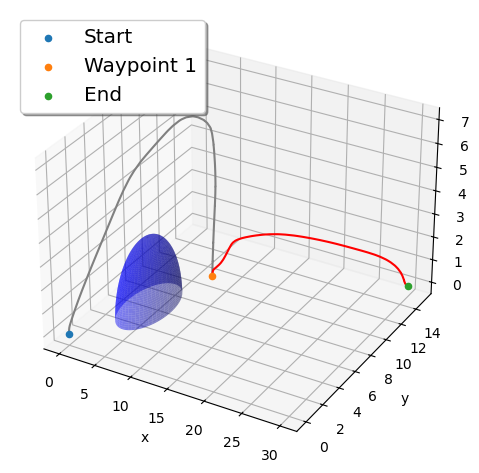

In [9]:
# Plot the 3D trajectory for the case with obstacles
x_traj = {"phase0": p.get_val("traj.phase0.timeseries.x") , "phase1": p.get_val("traj.phase1.timeseries.x")}
y_traj = {"phase0": p.get_val("traj.phase0.timeseries.y") , "phase1": p.get_val("traj.phase1.timeseries.y")}
z_traj = {"phase0": p.get_val("traj.phase0.timeseries.z") , "phase1": p.get_val("traj.phase1.timeseries.z")}

ax = plt.axes(projection='3d')
ax.plot3D(x_traj["phase0"], y_traj["phase0"], z_traj["phase0"], 'gray')
ax.scatter3D(x_traj["phase0"][0], y_traj["phase0"][0], z_traj["phase0"][0], 'gray', marker='o',label='Start')
ax.scatter3D(x_traj["phase0"][-1], y_traj["phase0"][-1], z_traj["phase0"][-1], 'gray', marker='o',label='Waypoint 1')
ax.plot3D(x_traj["phase1"], y_traj["phase1"], z_traj["phase1"], 'red')
ax.scatter3D(x_traj["phase1"][-1], y_traj["phase1"][-1], z_traj["phase1"][-1], 'red', marker='o',label='End')

# Define the parameters for the semi-sphere
x_center, y_center, z_center = 5, 5, 0
radius = 3.0

# Generate points on the semi-sphere's surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi / 2, 100)
x_semi_sphere = radius * np.outer(np.cos(u), np.sin(v)) + x_center
y_semi_sphere = radius * np.outer(np.sin(u), np.sin(v)) + y_center
z_semi_sphere = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + z_center

# Plot the semi-sphere
ax.plot_surface(x_semi_sphere, y_semi_sphere, z_semi_sphere, color='blue', alpha=0.5)  # You can adjust the color and alpha as needed

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'trajectory3D_obs.png'))
plt.show()

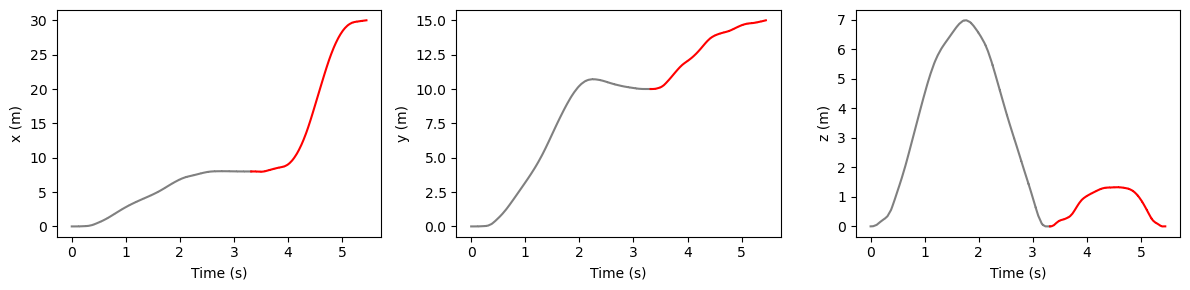

In [10]:
# Use plot_fun function to plot the results of x,y,z vs time for the case with obstacles
x_hist = {"phase0": p.get_val("traj.phase0.timeseries.x") , "phase1": p.get_val("traj.phase1.timeseries.x")}
y_hist = {"phase0": p.get_val("traj.phase0.timeseries.y") , "phase1": p.get_val("traj.phase1.timeseries.y")}
z_hist = {"phase0": p.get_val("traj.phase0.timeseries.z") , "phase1": p.get_val("traj.phase1.timeseries.z")}

time = {"phase0": p.get_val("traj.phase0.timeseries.time") , "phase1": p.get_val("traj.phase1.timeseries.time")}

plot_vs_time(x_hist,y_hist,z_hist,time,filename = 'xyz_obs.png',directory_path = figure_path, color_dict = {'color1':'gray','color2':'red'},label={'ax_x':'Time (s)','ax0_y':'x (m)','ax1_y':'y (m)','ax2_y':'z (m)'})

<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_8041/3804352040.py:9: SyntaxWarning: invalid escape sequence '\p'
  plot_vs_time(phi_hist,theta_hist,psi_hist,time,filename = 'phi_theta_psi_obs.png',directory_path=figure_path, color_dict = {'color1':'gray','color2':'red'},label={'ax_x':'Time (s)','ax0_y':'$\phi$ (rad)','ax1_y':'$\\theta$ (rad)','ax2_y':'$\psi$ (rad)'})
/tmp/ipykernel_8041/3804352040.py:9: SyntaxWarning: invalid escape sequence '\p'
  plot_vs_time(phi_hist,theta_hist,psi_hist,time,filename = 'phi_theta_psi_obs.png',directory_path=figure_path, color_dict = {'color1':'gray','color2':'red'},label={'ax_x':'Time (s)','ax0_y':'$\phi$ (rad)','ax1_y':'$\\theta$ (rad)','ax2_y':'$\psi$ (rad)'})


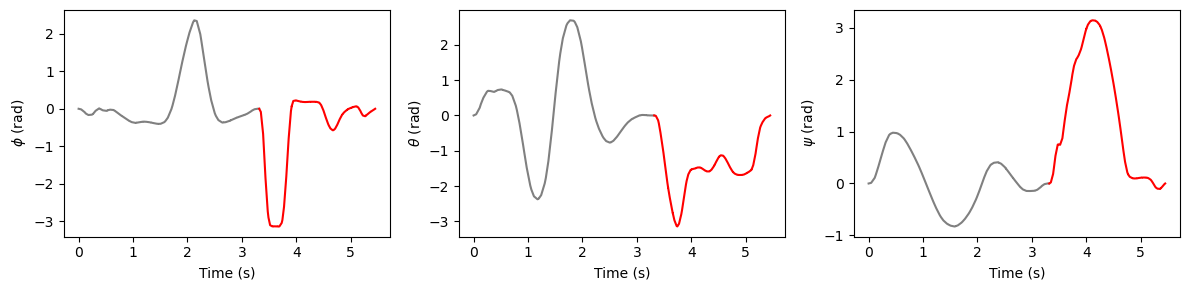

In [11]:
# Use plot_vs_time function to plot the results of phi,theta,psi vs time
phi_hist = {"phase0": p.get_val("traj.phase0.timeseries.phi") , "phase1": p.get_val("traj.phase1.timeseries.phi")}
theta_hist = {"phase0": p.get_val("traj.phase0.timeseries.theta") , "phase1": p.get_val("traj.phase1.timeseries.theta")}
psi_hist = {"phase0": p.get_val("traj.phase0.timeseries.psi") , "phase1": p.get_val("traj.phase1.timeseries.psi")}

time = {"phase0": p.get_val("traj.phase0.timeseries.time") , "phase1": p.get_val("traj.phase1.timeseries.time")}

# axis labels should be in latex format
plot_vs_time(phi_hist,theta_hist,psi_hist,time,filename = 'phi_theta_psi_obs.png',directory_path=figure_path, color_dict = {'color1':'gray','color2':'red'},label={'ax_x':'Time (s)','ax0_y':'$\phi$ (rad)','ax1_y':'$\\theta$ (rad)','ax2_y':'$\psi$ (rad)'})

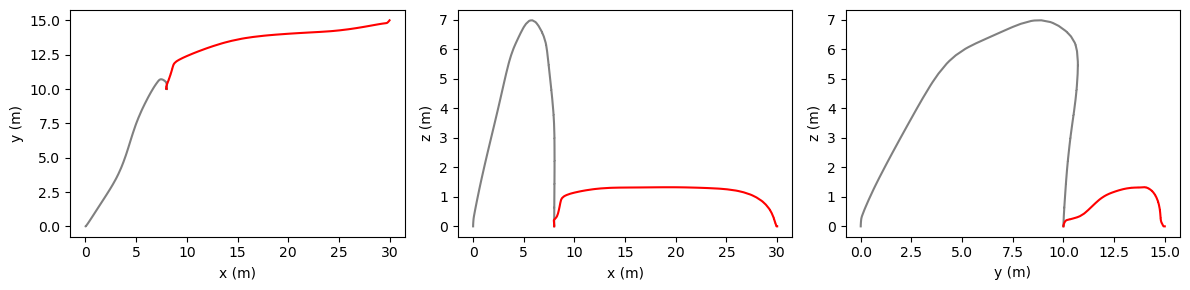

In [12]:
# plot 2d trajectory with obstacle, top view,front view, side view
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
axes[0].plot(x_traj["phase0"], y_traj["phase0"], 'gray')
axes[0].plot(x_traj["phase1"], y_traj["phase1"], 'red')
# Plot the obstacle
axes[0].set_xlabel('x (m)')
axes[0].set_ylabel('y (m)')
axes[1].plot(x_traj["phase0"], z_traj["phase0"], 'gray')
axes[1].plot(x_traj["phase1"], z_traj["phase1"], 'red')
axes[1].set_xlabel('x (m)')
axes[1].set_ylabel('z (m)')
axes[2].plot(y_traj["phase0"], z_traj["phase0"], 'gray')
axes[2].plot(y_traj["phase1"], z_traj["phase1"], 'red')
axes[2].set_xlabel('y (m)')
axes[2].set_ylabel('z (m)')
plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'trajectory2D_obs.png'))
plt.show()


<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_8041/2410893454.py:6: SyntaxWarning: invalid escape sequence '\d'
  plot_vs_time(x_dot_hist,y_dot_hist,z_dot_hist,time,filename = 'xyz_dot_obs.png',directory_path = figure_path, color_dict = {'color1':'gray','color2':'red'},label={'ax_x':'Time (s)','ax0_y':'$\dot{x}$ (m/s)','ax1_y':'$\dot{y}$ (m/s)','ax2_y':'$\dot{z}$ (m/s)'})
/tmp/ipykernel_8041/2410893454.py:6: SyntaxWarning: invalid escape sequence '\d'
  plot_vs_time(x_dot_hist,y_dot_hist,z_dot_hist,time,filename = 'xyz_dot_obs.png',directory_path = figure_path, color_dict = {'color1':'gray','color2':'red'},label={'ax_x':'Time (s)','ax0_y':'$\dot{x}$ (m/s)','ax1_y':'$\dot{y}$ (m/s)','ax2_y':'$\dot{z}$ (m/s)'})
/tmp/ipykern

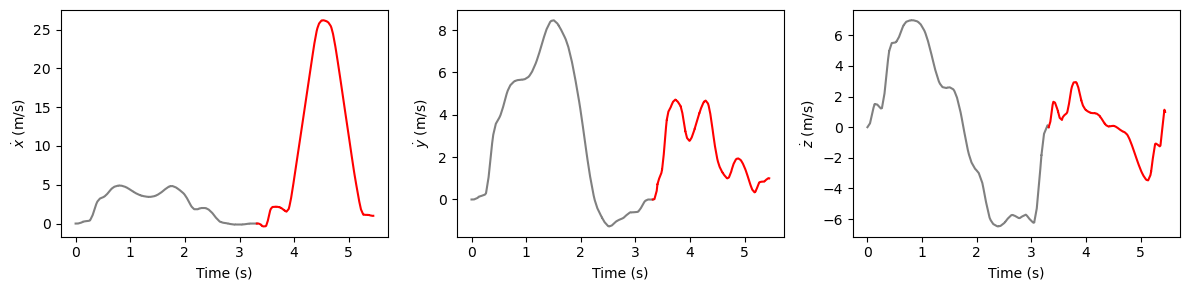

In [13]:
# Plot the x_dot, y_dot, z_dot vs time using plot_vs_time function
x_dot_hist = {"phase0": p.get_val("traj.phase0.timeseries.x_dot") , "phase1": p.get_val("traj.phase1.timeseries.x_dot")}
y_dot_hist = {"phase0": p.get_val("traj.phase0.timeseries.y_dot") , "phase1": p.get_val("traj.phase1.timeseries.y_dot")}
z_dot_hist = {"phase0": p.get_val("traj.phase0.timeseries.z_dot") , "phase1": p.get_val("traj.phase1.timeseries.z_dot")}

plot_vs_time(x_dot_hist,y_dot_hist,z_dot_hist,time,filename = 'xyz_dot_obs.png',directory_path = figure_path, color_dict = {'color1':'gray','color2':'red'},label={'ax_x':'Time (s)','ax0_y':'$\dot{x}$ (m/s)','ax1_y':'$\dot{y}$ (m/s)','ax2_y':'$\dot{z}$ (m/s)'})

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_8041/2627376950.py:6: SyntaxWarning: invalid escape sequence '\d'
  plot_vs_time(phi_dot_hist,theta_dot_hist,psi_dot_hist,time,filename = 'phi_dot_theta_dot_psi_dot_obs.png',directory_path=figure_path, color_dict = {'color1':'gray','color2':'red'},label={'ax_x':'Time (s)','ax0_y':'$\dot{\phi}$ (rad/s)','ax1_y':'$\dot{\\theta}$ (rad/s)','ax2_y':'$\dot{\psi}$ (rad/s)'})
/tmp/ipykernel_8041/2627376950.py:6: SyntaxWarning: invalid escape sequence '\d'
  plot_vs_time(phi_dot_hist,theta_dot_hist,psi_dot_hist,time,filename = 'phi_dot_theta_dot_psi_dot_obs.png',directory_path=figure_path, color_dict = {'color1':'gray','color2':'red'},label={'ax_x':'Time (s)','ax0_y':'$\dot{\phi}$ (rad

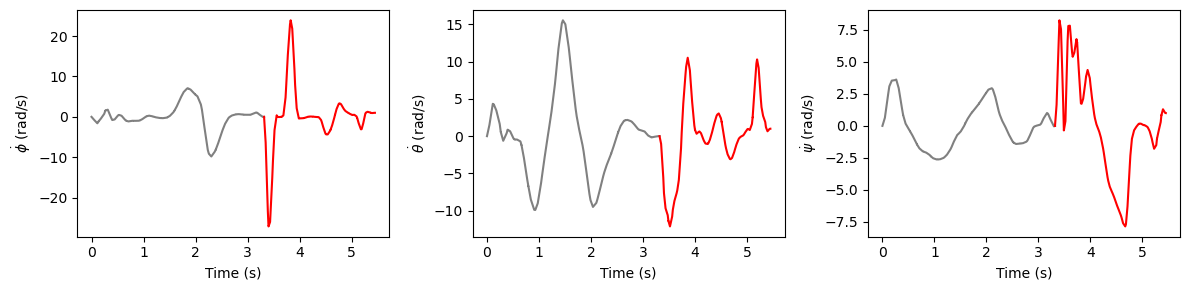

In [14]:
# phi_dot, theta_dot, psi_dot vs time using plot_vs_time function
phi_dot_hist = {"phase0": p.get_val("traj.phase0.timeseries.phi_dot") , "phase1": p.get_val("traj.phase1.timeseries.phi_dot")}
theta_dot_hist = {"phase0": p.get_val("traj.phase0.timeseries.theta_dot") , "phase1": p.get_val("traj.phase1.timeseries.theta_dot")}
psi_dot_hist = {"phase0": p.get_val("traj.phase0.timeseries.psi_dot") , "phase1": p.get_val("traj.phase1.timeseries.psi_dot")}

plot_vs_time(phi_dot_hist,theta_dot_hist,psi_dot_hist,time,filename = 'phi_dot_theta_dot_psi_dot_obs.png',directory_path=figure_path, color_dict = {'color1':'gray','color2':'red'},label={'ax_x':'Time (s)','ax0_y':'$\dot{\phi}$ (rad/s)','ax1_y':'$\dot{\\theta}$ (rad/s)','ax2_y':'$\dot{\psi}$ (rad/s)'})

<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_8041/4204541573.py:11: SyntaxWarning: invalid escape sequence '\o'
  axes[0].set_ylabel('$\omega_1$ (rad/s)')
/tmp/ipykernel_8041/4204541573.py:15: SyntaxWarning: invalid escape sequence '\o'
  axes[1].set_ylabel('$\omega_2$ (rad/s)')
/tmp/ipykernel_8041/4204541573.py:19: SyntaxWarning: invalid escape sequence '\o'
  axes[2].set_ylabel('$\omega_3$ (rad/s)')
/tmp/ipykernel_8041/4204541573.py:23: SyntaxWarning: invalid escape sequence '\o'
  axes[3].set_ylabel('$\omega_4$ (rad/s)')


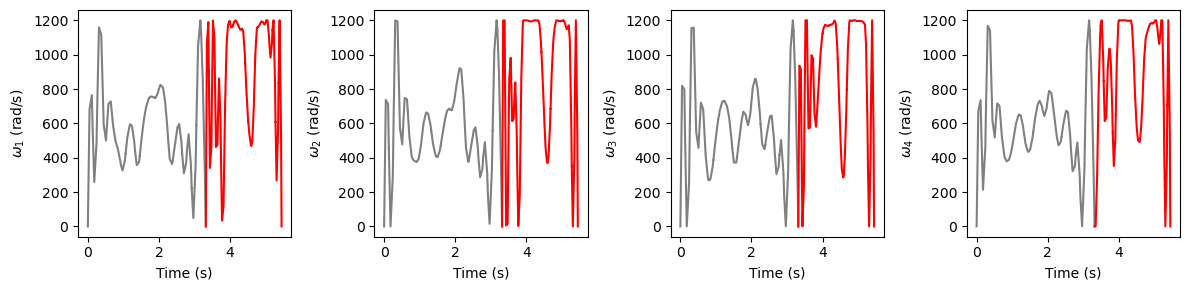

In [15]:
# w1, w2, w3, w4 vs time
w1_hist = {"phase0": p.get_val("traj.phase0.timeseries.w1") , "phase1": p.get_val("traj.phase1.timeseries.w1")}
w2_hist = {"phase0": p.get_val("traj.phase0.timeseries.w2") , "phase1": p.get_val("traj.phase1.timeseries.w2")}
w3_hist = {"phase0": p.get_val("traj.phase0.timeseries.w3") , "phase1": p.get_val("traj.phase1.timeseries.w3")}
w4_hist = {"phase0": p.get_val("traj.phase0.timeseries.w4") , "phase1": p.get_val("traj.phase1.timeseries.w4")}
time = {"phase0": p.get_val("traj.phase0.timeseries.time") , "phase1": p.get_val("traj.phase1.timeseries.time")}
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
axes[0].plot(time["phase0"], w1_hist["phase0"], 'gray')
axes[0].plot(time["phase1"], w1_hist["phase1"], 'red')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('$\omega_1$ (rad/s)')
axes[1].plot(time["phase0"], w2_hist["phase0"], 'gray')
axes[1].plot(time["phase1"], w2_hist["phase1"], 'red')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('$\omega_2$ (rad/s)')
axes[2].plot(time["phase0"], w3_hist["phase0"], 'gray')
axes[2].plot(time["phase1"], w3_hist["phase1"], 'red')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('$\omega_3$ (rad/s)')
axes[3].plot(time["phase0"], w4_hist["phase0"], 'gray')
axes[3].plot(time["phase1"], w4_hist["phase1"], 'red')
axes[3].set_xlabel('Time (s)')
axes[3].set_ylabel('$\omega_4$ (rad/s)')
plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'w1w2w3w4_vs_time_obs.png'))
plt.show()

In [ ]:
# Print time duration vs iteration
# cr = om.CaseReader('traj_obs.sql')
# cr1 = om.CaseReader('simple_traj.sql')
# sources = cr.list_sources()

cr = om.CaseReader('traj_obs_NSGA2.sql')

In [ ]:
driver_cases = cr.get_cases('driver', recurse=False)
time_duration = []
for case in driver_cases:
    time_duration.append(case['time_calcs.f'])

In [ ]:
cr1 = om.CaseReader('traj_obs.sql')

In [ ]:
driver_cases1 = cr1.get_cases('driver', recurse=False)
time_duration1 = []
for case in driver_cases1:
    time_duration1.append(case['time_calcs.f'])

In [ ]:
# Plot time duration vs iteration for two cases on one graph, x axis should be log scale
plt.semilogx(time_duration1, label='IPOPT')
plt.semilogx(time_duration, label='NSGA2')
plt.xlabel('Iteration')
plt.ylabel('Time Duration (s)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'time_duration_vs_iteration_optimizer_compare.pdf'))
plt.show()

In [ ]:
print('Case: 2, Total time duration: ', time_duration[-1], 's')

In [ ]:
#print out all initial and final states
print('Initial state of phase 0')
print('x_dot: ',p.get_val('traj.phase0.states:x_dot')[0])
print('y_dot: ',p.get_val('traj.phase0.states:y_dot')[0])
print('z_dot: ',p.get_val('traj.phase0.states:z_dot')[0])
print('x: ',p.get_val('traj.phase0.states:x')[0])
print('y: ',p.get_val('traj.phase0.states:y')[0])
print('z: ',p.get_val('traj.phase0.states:z')[0])
print('phi_dot: ',p.get_val('traj.phase0.states:phi_dot')[0])
print('theta_dot: ',p.get_val('traj.phase0.states:theta_dot')[0])
print('psi_dot: ',p.get_val('traj.phase0.states:psi_dot')[0])
print('phi: ',p.get_val('traj.phase0.states:phi')[0])
print('theta: ',p.get_val('traj.phase0.states:theta')[0])
print('psi: ',p.get_val('traj.phase0.states:psi')[0])
print('w1: ',p.get_val('traj.phase0.controls:w1')[0])
print('w2: ',p.get_val('traj.phase0.controls:w2')[0])
print('w3: ',p.get_val('traj.phase0.controls:w3')[0])
print('w4: ',p.get_val('traj.phase0.controls:w4')[0])

In [ ]:
om.n2(p)